In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

def gini_f(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini_f(actual, pred) / gini_f(actual, actual)

# Defining a new rank order metric

This new rank order metric is meant to mathematically capture higher predictions corresponding to higher actuals,
in the specific context where there are lots of zeros in the data and normal rank order metrics may be inadequate. 
We play off of the lift chart visualizations that cut predictions into tiers and view the average actual by tier,
by attempting to quantify how good this chart would be for our data.

The new metric is calculated as follows:
1. Cut predictions into n tiers, and find the average actual of each tier.
2. Calculate a monotonicity score between the tier number and the average tier
actuals. This is meant to quantify the extent to which each tier's average is higher
than the previous. The default is to use spearmanr.
3. Calculate the slope of the tier number with the average tier actual. This indicates the separation between
tiers and steepness of the lift chart.
4. Calculate a final combined score as penalized_monotonicity * slope. We penalize monotonicity by
replacing the monotonicity score with 1 - penalty(1 - monotonicity). If penalty > 1, this amplifies the
monotonicity's deviance from 1, assigning greater value to perfect monotonicity. 


**Caveats to this metric**
- The slope inherently depends on the scale of the data and the number of bins used. Thus, at present we can't use this metric to compare
across different datasets, but it can be useful for comparing different rank orderings of the same actuals with the same number of bins.
- Monotonicities are usually quite high even when the bins don't rank order perfectly. For this reason, finding the right 
monotonicity penalty is key.

In [13]:
# i think this is the move!!!!

def rank_order_test(predictions, actuals, n_bins, penalty = 1, verbose = True):
    """ 
    Given two arrays of predictions and actuals, calculate custom rank order score.
    This is performed in the following way:

    1. Cut predictions into n_bins tiers, and find the average actual of each tier.
    2. Calculate a monotonicity score: the extent to which each tier's average is greater
        than the previous tier's.
    3. Calculate the slope of the tier averages - captures the "steepness" or degree of
        separation between tiers.
    4. Return monotonicity * slope as the rank order score - the score is primarily based on
        slope, but decreases for imperfect monotonicity.

    CAVEAT: This method is only comparable for actuals on the same scale (i.e. evaluating different
        models on the same dataset) and for the same n_bins - increasing n_bins will generally 
        decrease the slope.

    :param predictions: Array of predictions.
    :param actuals: Array of actuals.
    :param n_bins: How many tiers to cut predictions into for calculation.
    :param print: Boolean, whether to print out a lift chart of prediction tiers vs. average actual
        and the monotonicity, slope, and combined scores
    :param monotonicity_metric: Which metric to use to measure monotonicity of tier + average actual.
        Default is spearmanr, but can also use kendalltau which is thought to better handle ties.

    :return: Monotonicity score, slope, combined score
    """
    df = pd.DataFrame({'pred': predictions, 'actual': actuals})
    df['pred_bin'] = pd.qcut(df['pred'], q = n_bins, labels = range(1, n_bins + 1))

    n_per_bin = len(df['actual']) // n_bins

    ordered_actuals = sorted(df['actual'])
    lowest_actual_tier = np.mean(ordered_actuals[:n_per_bin])
    highest_actual_tier = np.mean(ordered_actuals[-n_per_bin:])
    #df['actual_bin'] = pd.qcut(df['actual'], q = n_bins, duplicates = 'drop')
    agg = df.groupby('pred_bin')['actual'].mean().reset_index()
    if verbose:

        sns.barplot(x = agg['pred_bin'], y = agg['actual'])
        plt.show()
    #acc_agg = df.groupby('actual_bin')['actual'].mean().reset_index()

    monotonicity = spearmanr(agg['pred_bin'], agg['actual'])[0]

    slope = (agg['actual'].iloc[-1] - agg['actual'].iloc[0])

    perfect_slope = (highest_actual_tier - lowest_actual_tier)
    slope = slope / perfect_slope

    # combined_metric = (1 - penalty*(1 - monotonicity)) * slope

    combined_metric = (monotonicity ** penalty) * slope

    if verbose:
        print(f'MONOTONICITY SCORE: {monotonicity: .4f}')
        print(f'SLOPE SCORE: {slope: .4f}')
        print(f'COMBINED SCORE: {combined_metric: .4f}')
    return monotonicity, slope, combined_metric

#rank_order_test(fpreds.flatten(), fdata.flatten(), 10, verbose = False, monotonicity_metric = spearmanr, penalty = 5, normalize_slope = True)

In [14]:
def rank_order(predictions, actuals, n_bins, verbose = True, monotonicity_metric = spearmanr, penalty = 1, normalize_slope = False):
    """ 
    Given two arrays of predictions and actuals, calculate custom rank order score.
    This is performed in the following way:

    1. Cut predictions into n_bins tiers, and find the average actual of each tier.
    2. Calculate a monotonicity score: the extent to which each tier's average is greater
        than the previous tier's.
    3. Calculate the slope of the tier averages - captures the "steepness" or degree of
        separation between tiers.
    4. Return monotonicity * slope as the rank order score - the score is primarily based on
        slope, but decreases for imperfect monotonicity.

    CAVEAT: This method is only comparable for actuals on the same scale (i.e. evaluating different
        models on the same dataset) and for the same n_bins - increasing n_bins will generally 
        decrease the slope.

    :param predictions: Array of predictions.
    :param actuals: Array of actuals.
    :param n_bins: How many tiers to cut predictions into for calculation.
    :param print: Boolean, whether to print out a lift chart of prediction tiers vs. average actual
        and the monotonicity, slope, and combined scores
    :param monotonicity_metric: Which metric to use to measure monotonicity of tier + average actual.
        Default is spearmanr, but can also use kendalltau which is thought to better handle ties.

    :return: Monotonicity score, slope, combined score
    """
    df = pd.DataFrame({'pred': predictions, 'actual': actuals})
    df['pred_bin'] = pd.qcut(df['pred'], q = n_bins, labels = range(1, n_bins + 1))
    agg = df.groupby('pred_bin')['actual'].mean().reset_index()
    if verbose:
        sns.barplot(x = agg['pred_bin'], y = agg['actual'])
        plt.show()

    monotonicity = monotonicity_metric(agg['pred_bin'], agg['actual'])[0]
    #slope = LinearRegression().fit(agg[['pred_bin']], agg[['actual']]).coef_[0][0]
    slope = (agg['actual'].iloc[-1] - agg['actual'].iloc[0]) / n_bins
    if normalize_slope:
        slope = slope * n_bins / 13

    combined_metric = (monotonicity - 0.9) / 0.1 * slope
    if verbose:
        print(f'MONOTONICITY SCORE: {monotonicity: .4f}')
        print(f'SLOPE SCORE: {slope: .4f}')
        print(f'COMBINED SCORE: {combined_metric: .4f}')
    return monotonicity, slope, combined_metric

def rank_order_simple(predictions, actuals, print = True, monotonicity_metric = spearmanr, penalty = 1):
    """
    Simpler version of rank_order function meant for easy testing. Inputs represent tier
    numbers and aggregated averages

    :param predictions: Array of tier numbers.
    :param actuals: Array of average actuals by tier.
    :param print: Boolean, whether to print out a lift chart of prediction tiers vs. average actual
        and the monotonicity, slope, and combined scores
    :param monotonicity_metric: Which metric to use to measure monotonicity of tier + average actual.
        Default is spearmanr, but can also use kendalltau which is thought to better handle ties.
    :param penalty: Amount by which to add extra penalty to combined score for non-monotonic graphs.

    :return: Monotonicity score, slope, combined score
    """
    if print:
        sns.barplot(x = predictions, y = actuals)
        plt.show()

    monotonicity = monotonicity_metric(actuals, predictions)[0]
    mon_penalty = 1 - penalty * (1 - monotonicity)
    slope = LinearRegression().fit(np.array(predictions).reshape(-1, 1), np.array(actuals).reshape(-1, 1)).coef_[0][0]

    combined_metric = mon_penalty * slope
    if print:
        print(f'MONOTONICITY SCORE: {monotonicity: .4f}')
        print(f'SLOPE SCORE: {slope: .4f}')
        print(f'COMBINED SCORE: {combined_metric: .4f}')
    return monotonicity, slope, combined_metric

# Test simulation

As a test, I wrote code that generates fake datasets and evaluates them using this new metric as well as spearman and gini.
I created a fake probability distribution that is meant to mimic the lift charts of warranty models, where most actuals are 0 and
actuals are more likely to be nonzero/larger as predictions get larger. I draw data from this distribution to make fake prediction tiers,
and calculate the new rank order metric using that.

I also assing fake continuous predictions to the data so that I can calculate a good-faith spearman and gini.

In [10]:
# probability distribution for 13 tiers with values between 0 and 12.
# meant to resemble the distribution of actual warranty values across tiers
# for a model with decent rank ordering - zeros are always the most probable, 
# but the probability of nonzero warranty increases with each tier, and 
# the probabilities of higher warranties increase with each tier.

probabilities = np.array([
[.925, .016, .014, .012, .01, .008, .006, .004, .002, .001, .0015, .0005, .0000],
[.9, .02, .016, .013, .012, .011, .009, .007, .005, .003, .002, .0015, .0005],
[.85, .02, .022, .02, .018, .016, .014, .012, .01, .008, .006, .003, .001],
[.8, .023, .026, .03, .024, .022, .019, .015, .013, .01, .008, .006, .004],
[.775, .023, .024, .027, .03, .025, .021, .019, .017, .014, .011, .008, .006],
[.75, .023, .025, .028, .03, .032, .026, .022, .019, .015, .012, .01, .008],
[.725, .022, .023, .025, .027, .029, .032, .029, .027, .023, .016, .012, .01],
[.7, .021, .022, .023, .027, .029, .031, .033, .031, .028, .025, .016, .014],
[.675, .02, .021, .024, .026, .028, .03, .032, .035, .032, .03, .025, .022],
[.65, .02, .021, .024, .026, .028, .031, .033, .035, .037, .035, .032, .028],
[.625, .022, .024, .026, .028, .03, .032, .033, .034, .036, .039, .037, .034],
[.6, .023, .026, .029, .031, .032, .033, .034, .035, .037, .039, .042, .039],
[.575, .024, .026, .028, .03, .032, .034, .037, .039, .041, .042, .045, .047],
])

In [15]:
def generate_data(n_samples = 10, n_tiers = 13, prob_dist = probabilities, max_value = 12):
    """
    Generate random data of size (n_tiers, n_samples). Follows
    probability distribution prob_dist when choosing each data sample.

    :param n_samples: Number of data points to sample per tier
    :param n_tiers: Number of tiers to use
    :param prob_dist: Probability distribution of size (n_tiers, range of possible values) that
        determines the probability of randomly selecting each possible value in each tier
    :param max_value: The maximum integer value of data to pull, assuming we pull data
        as integers from 0 to max_value.

    :return: (n_tiers, n_samples) fake dataset.
    """
    arr = np.zeros((n_tiers, n_samples), dtype = int)
    for row in range(n_tiers):
        probs = prob_dist[row]
        arr[row] = np.random.choice(range(max_value + 1), size=n_samples, p=probs)
    return arr

def simulation_test(n_simulations, n_samples, n_tiers = 13, prob_dist = probabilities, max_value = 12, 
                    print_charts = True, monotonicity_metric = spearmanr, mon_penalty = 1, normalize_slope = False):
    
    """ 
    Generate fake data n_simulations times and return rank order measures for each simulation.

    :param n_simulations: Number of simulations to run
    :param n_samples: Number of data points to sample per tier
    :param n_tiers: Number of tiers to use
    :param prob_dist: Probability distribution of size (n_tiers, range of possible values) that
        determines the probability of randomly selecting each possible value in each tier
    :param max_value: The maximum integer value of data to pull, assuming we pull data
        as integers from 0 to max_value.  
    :param print_charts: Boolean, whether to print graphs of the fake datasets with the 
        best scores for each metric.
    :param monotonicity_metric: Which metric to use to measure monotonicity of tier + average actual.
        Default is spearmanr, but can also use kendalltau which is thought to better handle ties.
    :param mon_penalty: Amount by which to add extra penalty to combined score for non-monotonic graphs.

    :return: datasets, scores
        where datasets is the (n_tiers, n_samples, n_simulations) array of all fake data
        and scores is the (5, n_simulations) array of the monotonicity score, slope,
            combined score, spearman correlation, and gini coefficient for each fake dataset.
    """

    # initialize arrays to return
    datasets = np.zeros((n_tiers, n_samples, n_simulations))
    scores = np.zeros((5, n_simulations))

    # for each simulation
    for i in range(n_simulations):
        # generate a fake dataset - fake actuals for each tier
        fake_data = generate_data(n_samples, n_tiers, prob_dist, max_value)
        # add this dataset to the datasets array
        datasets[:, :, i] = fake_data
        # generate continuous fake predictions - tier number plus a small decimal
        # need to do this to have more honest spearman/gini calculations.
        p = np.linspace(0, 1, num = n_samples, endpoint = False).reshape(1, n_samples)
        p = np.repeat(p, n_tiers, axis = 0)
        fake_preds = p + np.array(range(n_tiers)).reshape(-1, 1)

        # get the mean "actual" for each tier
        # calculate custom rank order measures and add to scores array
        mon, slope, combined = rank_order_test(fake_preds.flatten(), fake_data.flatten(), n_tiers, penalty = mon_penalty, verbose = False)
        scores[0, i] = mon
        scores[1, i] = slope
        scores[2, i] = combined

        # calculate spearman correlation and gini coefficient, add to scores array
        scores[3, i] = spearmanr(fake_preds.flatten(), fake_data.flatten())[0]
        scores[4, i] = gini_normalized(fake_data.flatten(), fake_preds.flatten())

    if print_charts:

        # find datasets that maximize and minimize each metric
        maximums = np.argmax(scores, axis = 1)
        minimums = np.argmin(scores, axis = 1)
        

        print('Simulation over {} datasets with {} samples per tier'.format(n_simulations, n_samples))
        print('\n')
        scorenames = ['monotonicity', 'slope', 'combined', 'spearman', 'gini']

        # print scores for and plot the datasets with the highest score of each metric
        for idx, i in enumerate(maximums):
            print('data with highest {} score'.format(scorenames[idx]))
            print('monotonicity: {:.4f}, slope: {:.4f}, combined score: {:.4f}, spearman: {:.4f}, gini: {:.4f}'.format(*scores[:, i]))
            temp_data = datasets[:, :, i]
            agg = np.mean(temp_data, axis = 1)
            sns.barplot(x = range(n_tiers), y = agg)
            plt.ylim((0, max_value / 2))
            plt.title('Highest {} score'.format(scorenames[idx]))
            plt.show()

        # print scores for and plot the datasets with the lowest score of each metric
        for idx, i in enumerate(minimums):
            print('data with lowest {} score'.format(scorenames[idx]))
            print('monotonicity: {:.4f}, slope: {:.4f}, combined score: {:.4f}, spearman: {:.4f}, gini: {:.4f}'.format(*scores[:, i]))
            temp_data = datasets[:, :, i]
            agg = np.mean(temp_data, axis = 1)
            sns.barplot(x = range(n_tiers), y = agg)
            plt.ylim((0, max_value / 2))
            plt.title('Lowest {} score'.format(scorenames[idx]))
            plt.show()

        # visualize slopes and monotonicities - how our custom score is calculated
        sns.scatterplot(x = scores[0], y = scores[1], hue = scores[2])
        plt.xlabel('Monotonicity')
        plt.ylabel('Slope')
        plt.title('Slope vs. Monotonicity, colored by combined score')
        plt.legend(title = 'Custom Score')
        plt.show()

        # visualize spearman and gini vs. our custom score
        sns.scatterplot(x = scores[3], y = scores[4], hue = scores[2])
        plt.xlabel('Spearman Correlation')
        plt.ylabel('Gini Coefficient')
        plt.title('Gini vs. Spearman, colored by combined score')
        plt.legend(title = 'Custom Score')
        plt.show()

    return datasets, scores

Simulation over 2000 datasets with 100 samples per tier


data with highest monotonicity score
monotonicity: 1.0000, slope: 0.3401, combined score: 0.3401, spearman: 0.2719, gini: 0.4080


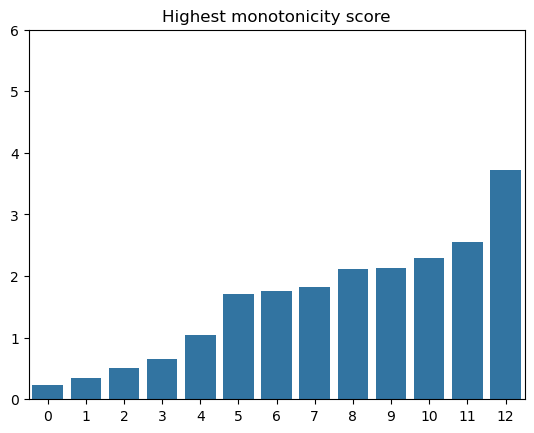

data with highest slope score
monotonicity: 0.9615, slope: 0.4661, combined score: 0.3831, spearman: 0.3202, gini: 0.4705


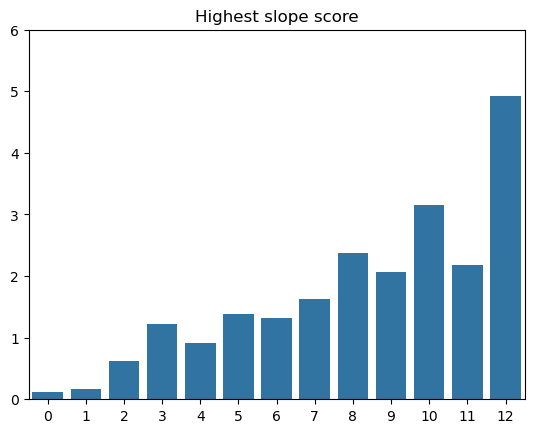

data with highest combined score
monotonicity: 0.9945, slope: 0.4111, combined score: 0.3999, spearman: 0.3388, gini: 0.4877


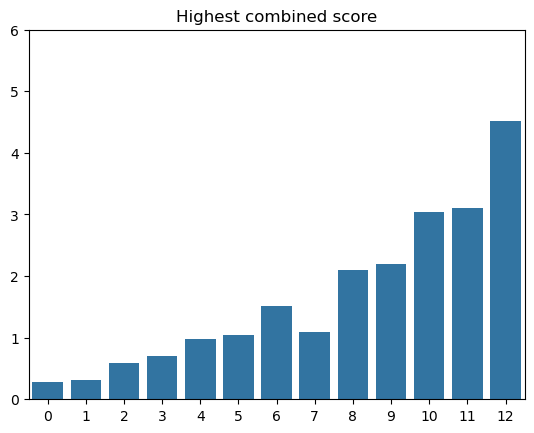

data with highest spearman score
monotonicity: 0.9945, slope: 0.4111, combined score: 0.3999, spearman: 0.3388, gini: 0.4877


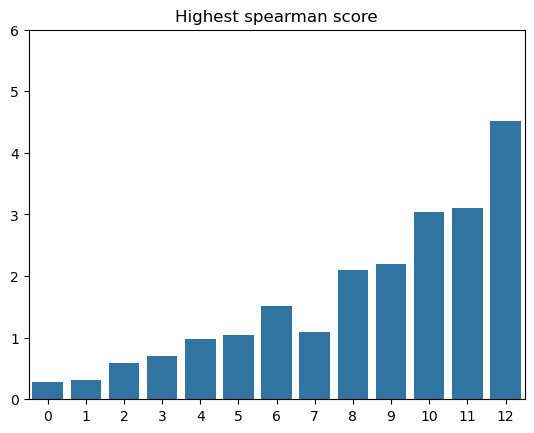

data with highest gini score
monotonicity: 0.9945, slope: 0.4111, combined score: 0.3999, spearman: 0.3388, gini: 0.4877


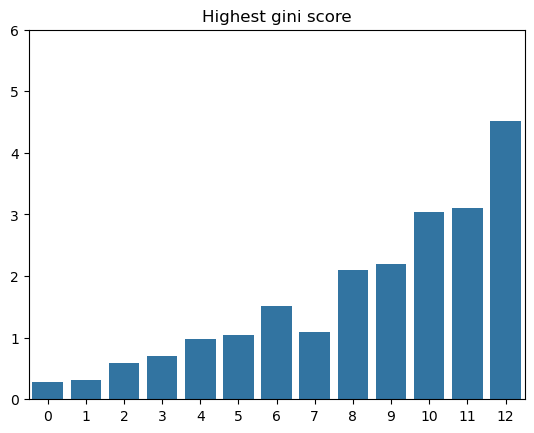

data with lowest monotonicity score
monotonicity: 0.8077, slope: 0.1845, combined score: 0.0634, spearman: 0.2317, gini: 0.3386


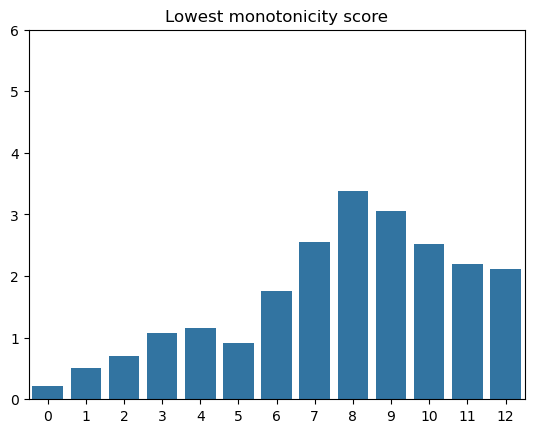

data with lowest slope score
monotonicity: 0.8571, slope: 0.1509, combined score: 0.0698, spearman: 0.2215, gini: 0.3345


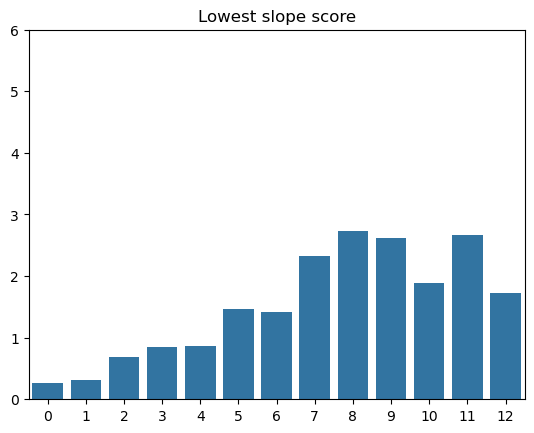

data with lowest combined score
monotonicity: 0.8077, slope: 0.1845, combined score: 0.0634, spearman: 0.2317, gini: 0.3386


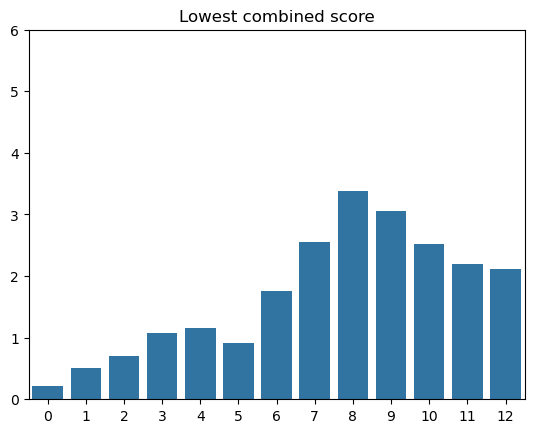

data with lowest spearman score
monotonicity: 0.9396, slope: 0.1629, combined score: 0.1193, spearman: 0.1762, gini: 0.3002


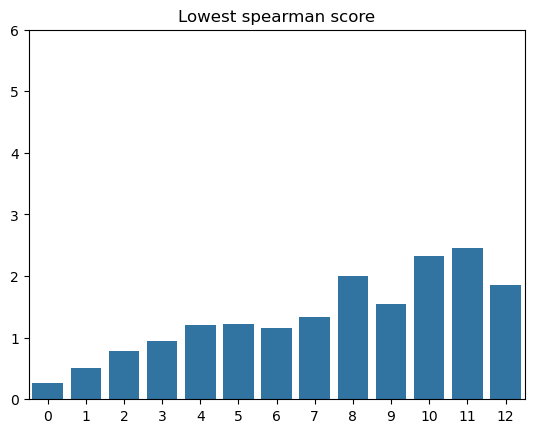

data with lowest gini score
monotonicity: 0.9519, slope: 0.2144, combined score: 0.1675, spearman: 0.1884, gini: 0.2698


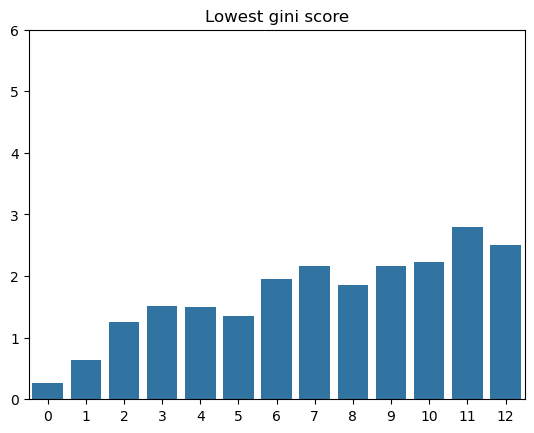

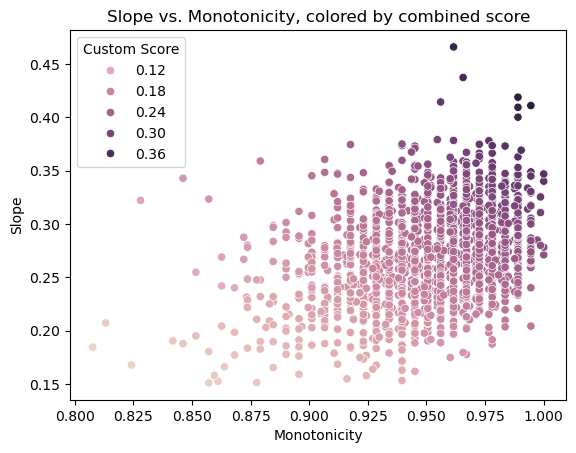

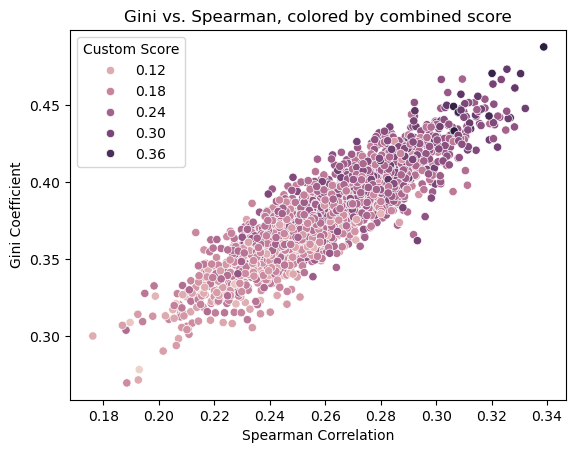

In [16]:
# run this cell to run the simulation!!

datasets, scores = simulation_test(2000, 100, n_tiers = 13, prob_dist= probabilities, max_value = 12, print_charts= True, monotonicity_metric=spearmanr,
                                   mon_penalty = 5, normalize_slope = True)

In [20]:
mon_translations = pd.DataFrame()
mon_translations['Raw Spearman'] = [1, 0.99, 0.98, 0.97, 0.96, 0.95, 0.925, 0.9, 0.85, 0.8, 0.75, 0.7, 0.5, 0.25, 0]
for p in range(1, 12):
    mon_translations[f'Penalty_{p}'] = np.round(mon_translations['Raw Spearman']**p, 2)

mon_translations

,Raw Spearman,Penalty_1,Penalty_2,Penalty_3,Penalty_4,Penalty_5,Penalty_6,Penalty_7,Penalty_8,Penalty_9,Penalty_10,Penalty_11
0,1.000,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,0.990,0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.90,0.90
2,0.980,0.98,0.96,0.94,0.92,0.90,0.89,0.87,0.85,0.83,0.82,0.80
3,0.970,0.97,0.94,0.91,0.89,0.86,0.83,0.81,0.78,0.76,0.74,0.72
4,0.960,0.96,0.92,0.88,0.85,0.82,0.78,0.75,0.72,0.69,0.66,0.64
5,0.950,0.95,0.90,0.86,0.81,0.77,0.74,0.70,0.66,0.63,0.60,0.57
6,0.925,0.92,0.86,0.79,0.73,0.68,0.63,0.58,0.54,0.50,0.46,0.42
7,0.900,0.90,0.81,0.73,0.66,0.59,0.53,0.48,0.43,0.39,0.35,0.31
8,0.850,0.85,0.72,0.61,0.52,0.44,0.38,0.32,0.27,0.23,0.20,0.17
9,0.800,0.80,0.64,0.51,0.41,0.33,0.26,0.21,0.17,0.13,0.11,0.09


In [44]:
# with 13 tiers, making one monotonicity mistake gives a spearman of 0.9945.
# we might ask, for different such penalties, how much does slope have to increase
# to get an equal score as perfect monotonicities for various penalties?

slope_penalties = np.zeros((10, 10))
for p in range(1, 11):
    for i, slope in enumerate(np.arange(0.1, 1, 0.1)):
        slope_penalties[i, p - 1] = (1 - 0.9945**p) * slope / (0.9945**p)

slope_penalties[:, 4]

array([0.00279596, 0.00559193, 0.00838789, 0.01118386, 0.01397982,
       0.01677578, 0.01957175, 0.02236771, 0.02516367, 0.        ])

0.9 0.97


(0.9, 0.97)

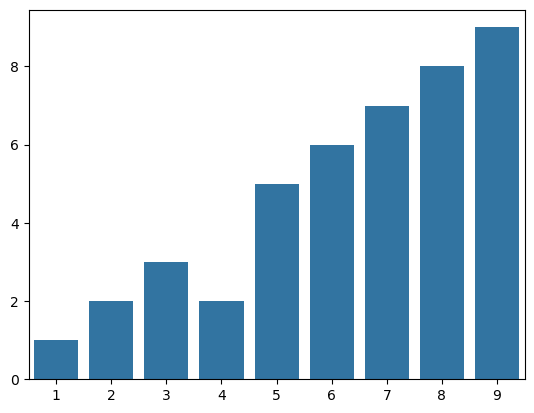

In [56]:
def new_monotonicity(avg_actuals):
    bin_numbers = range(1, len(avg_actuals) + 1)
    negative_delta = 0
    total_delta = 0
    for i in range(len(avg_actuals) - 1):
        if avg_actuals[i + 1] < avg_actuals[i]:
            negative_delta += np.abs(avg_actuals [i+1] - avg_actuals[i])
        total_delta += np.abs(avg_actuals [i+1] - avg_actuals[i])
    sns.barplot(x = bin_numbers, y =avg_actuals)
    print(round(1 - negative_delta/total_delta, 2), round(spearmanr(bin_numbers, avg_actuals)[0], 2))

    # will throw a division by zero error if strictly decreasing
    return round(1 - negative_delta/total_delta, 2), round(spearmanr(bin_numbers, avg_actuals)[0], 2)


new_monotonicity([1, 2, 3, 2, 5, 6, 7, 8, 9])

In [55]:
spearmanr(range(1, 11), [1, 3, 2, 4, 5, 3, 4.5, 7, 8, 10])

SignificanceResult(statistic=0.9057792600832962, pvalue=0.00030732288058894243)

In [40]:
def match_spearman(rho):
    val = 364*(1 - rho)
    tiernums = np.array(range(1, 14))
    stop = False
    while stop == False:
        bins = np.random.randint(1, 14, size = 13)
        diff = (tiernums - bins)**2
        if np.abs(np.sum(diff) - val) <= 1:
            stop = True
            return bins
        
b = match_spearman(0.95)

KeyboardInterrupt: 

In [35]:
spearmanr(b, range(1, 14))

SignificanceResult(statistic=0.7508446316719045, pvalue=0.0030982335506180517)

In [61]:
# prob dist shape (n_tiers, n_possible_values)

# generate simple probability distribution for 50 tiers: prob of nonzero increases with each 
# tier, and the value that matches tier number gets an extra bump

initial_row = [.975] + [5.10204e-4]*49

prob_dist_50 = np.zeros((50, 50))

prob_dist_50[0, :] = initial_row
for i in range(1,50):
    p_zero = .975 - i*.0095
    prob_dist_50[i, 0] = p_zero
    prob_dist_50[i, 1:i] = prob_dist_50[i - 1, 1:i] + 1.9e-4
    prob_dist_50[i, i] = prob_dist_50[i - 1, i] + 2 * 1.9e-4
    prob_dist_50[i, i + 1:] = prob_dist_50[i - 1, i + 1:] + 1.9e-4

# print(np.sum(prob_dist_50, axis = 1))
# print(prob_dist_50)

In [14]:
def create_prob_dist(n_tiers):
    initial_row = [.975] + [(1 - .975) / (n_tiers - 1)]*(n_tiers - 1)
    p_dist = np.zeros((n_tiers, n_tiers))

    p_dist[0, :] = initial_row
    for i in range(1, n_tiers):
        gain = (.975 - .5) / (n_tiers - 1)
        p_zero = .975 - i * gain
        p_dist[i, 0] = p_zero
        p_dist[i, 1:i] = p_dist[i - 1, 1:i] + gain / (n_tiers)
        p_dist[i, i] = p_dist[i - 1, i] + 2 * gain / n_tiers
        p_dist[i, i + 1:] = p_dist[i - 1, i + 1:] + gain / n_tiers

    return p_dist

Simulation over 100 datasets with 100 samples per tier


data with highest monotonicity score
monotonicity: 0.9853, slope: 0.2489, combined score: 0.2124, spearman: 0.3485, gini: 0.4201


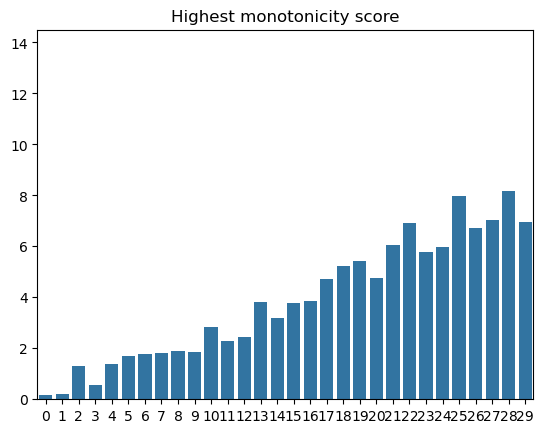

data with highest slope score
monotonicity: 0.9316, slope: 0.3416, combined score: 0.1079, spearman: 0.3272, gini: 0.3984


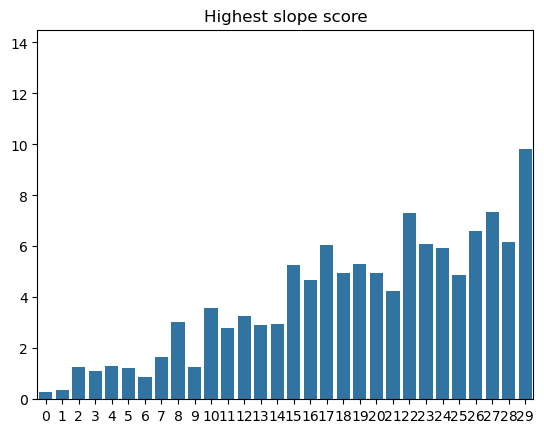

data with highest combined score
monotonicity: 0.9825, slope: 0.2809, combined score: 0.2319, spearman: 0.3411, gini: 0.4065


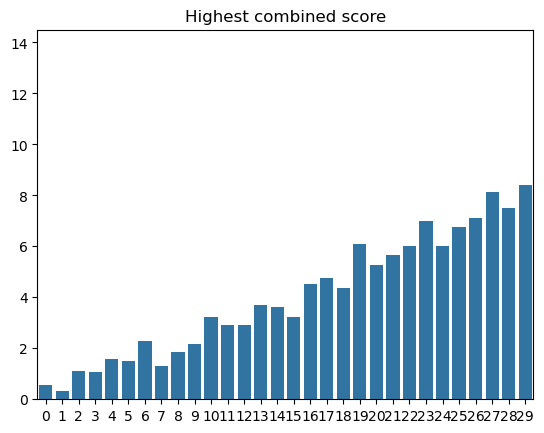

data with highest spearman score
monotonicity: 0.9853, slope: 0.2489, combined score: 0.2124, spearman: 0.3485, gini: 0.4201


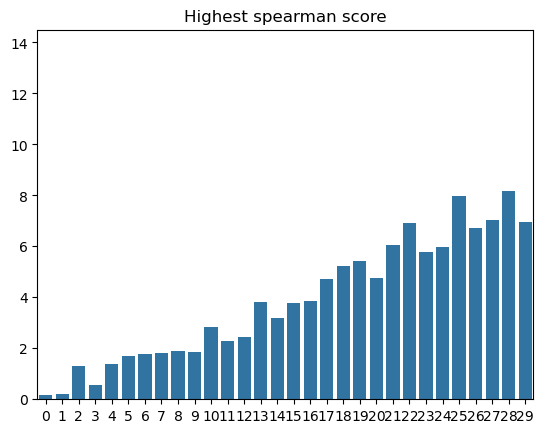

data with highest gini score
monotonicity: 0.9638, slope: 0.3062, combined score: 0.1955, spearman: 0.3373, gini: 0.4235


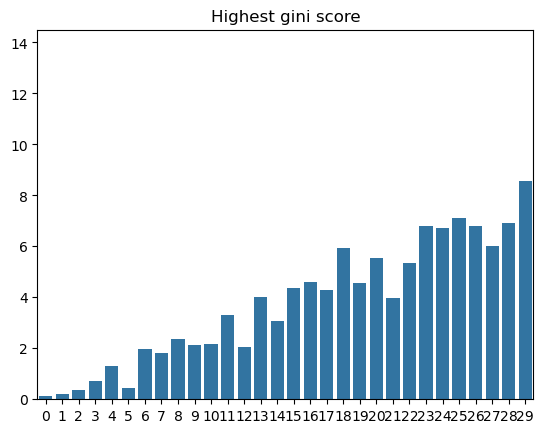

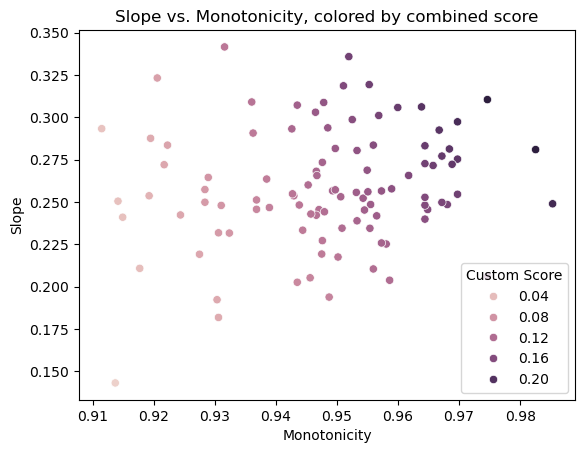

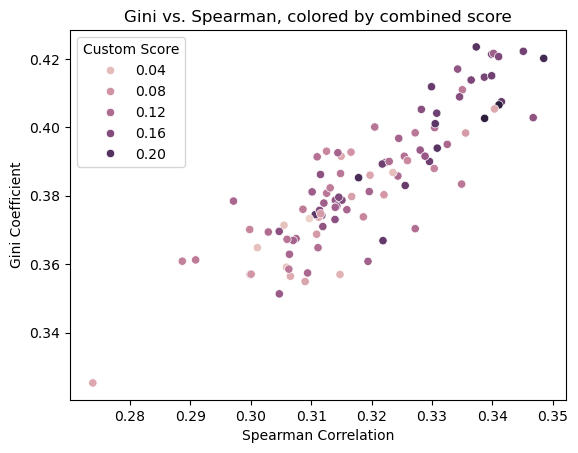

In [15]:
datasets, scores = simulation_test(100, 100, n_tiers = 30, prob_dist= create_prob_dist(30), max_value = 29, print_charts= True, monotonicity_metric=spearmanr,
                                   mon_penalty = 10)

In [68]:
dset_good_example = datasets
scores_good_example = scores

In [163]:
def score_datasets(datasets, mon_penalty, monotonicity_metric, print_charts = True):
    """ 
    Given datasets previously generated, score them.

    This allows us to test out how results change when we use
    different monotonicity penalties and different
    monotonicity metrics.
    """
    n_tier, n_sample, n_dset = datasets.shape
    for i in range(n_dset):
        fake_data = datasets[:, :, i]
        # generate continuous fake predictions - tier number plus a small decimal
        # need to do this to have more honest spearman/gini calculations.
        p = np.linspace(0, 1, num = n_sample, endpoint = False).reshape(1, n_sample)
        p = np.repeat(p, n_tier, axis = 0)
        fake_preds = p + np.array(range(n_tier)).reshape(-1, 1)

        # get the mean "actual" for each tier
        agg = np.mean(fake_data, axis = 1)
        # calculate custom rank order measures and add to scores array
        mon, slope, combined = rank_order_simple(range(n_tier), agg, print = False, monotonicity_metric = monotonicity_metric,
                                                 penalty= mon_penalty)
        scores[0, i] = mon
        scores[1, i] = slope
        scores[2, i] = combined

        # calculate spearman correlation and gini coefficient, add to scores array
        scores[3, i] = spearmanr(fake_preds.flatten(), fake_data.flatten())[0]
        scores[4, i] = gini_normalized(fake_data.flatten(), fake_preds.flatten())

    if print_charts:

        # find datasets that maximize and minimize each metric
        maximums = np.argmax(scores, axis = 1)
        

        print('Simulation over {} datasets with {} samples per tier'.format(n_dset, n_sample))
        print('\n')
        scorenames = ['monotonicity', 'slope', 'combined', 'spearman', 'gini']

        # print scores for and plot the datasets with the highest score of each metric
        for idx, i in enumerate(maximums):
            print('data with highest {} score'.format(scorenames[idx]))
            print('monotonicity: {:.4f}, slope: {:.4f}, combined score: {:.4f}, spearman: {:.4f}, gini: {:.4f}'.format(*scores[:, i]))
            temp_data = datasets[:, :, i]
            agg = np.mean(temp_data, axis = 1)
            sns.barplot(x = range(n_tier), y = agg)
            plt.xlabel('Prediction Tier')
            plt.ylabel('Average Actual')
            plt.ylim((0, (n_tier - 1) / 2))
            plt.title('Highest {} score'.format(scorenames[idx]))
            plt.show()

        # visualize slopes and monotonicities - how our custom score is calculated
        sns.scatterplot(x = scores[0], y = scores[1], hue = scores[2])
        plt.xlabel('Monotonicity')
        plt.ylabel('Slope')
        plt.title('Slope vs. Monotonicity, colored by combined score')
        plt.legend(title = 'Custom Score')
        plt.show()

        # visualize spearman and gini vs. our custom score
        sns.scatterplot(x = scores[3], y = scores[4], hue = scores[2])
        plt.xlabel('Spearman Correlation')
        plt.ylabel('Gini Coefficient')
        plt.title('Gini vs. Spearman, colored by combined score')
        plt.legend(title = 'Custom Score')
        plt.show()

    return scores

Simulation over 100 datasets with 100 samples per tier


data with highest monotonicity score
monotonicity: 0.9889, slope: 0.2624, combined score: 0.2537, spearman: 0.3371, gini: 0.4108


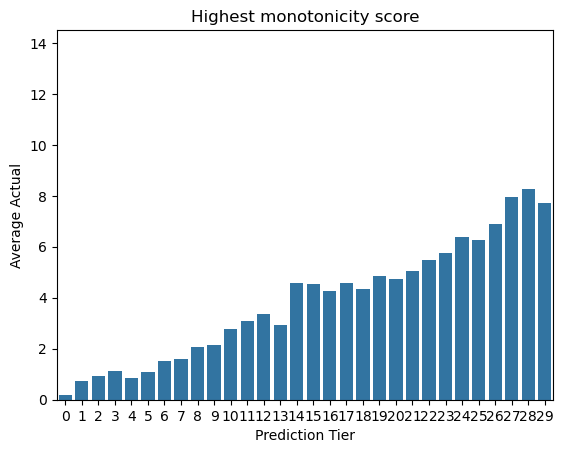

data with highest slope score
monotonicity: 0.9311, slope: 0.2972, combined score: 0.2358, spearman: 0.3577, gini: 0.4358


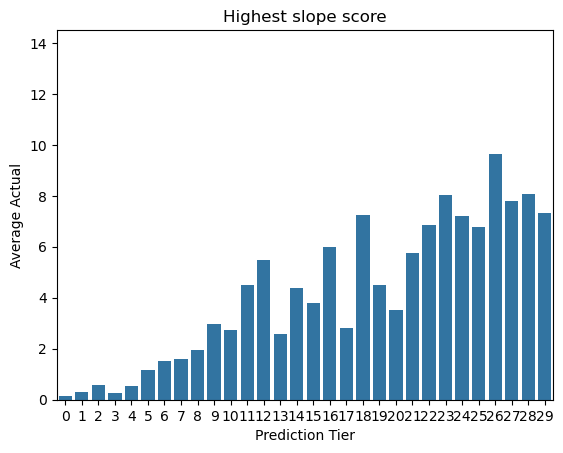

data with highest combined score
monotonicity: 0.9889, slope: 0.2624, combined score: 0.2537, spearman: 0.3371, gini: 0.4108


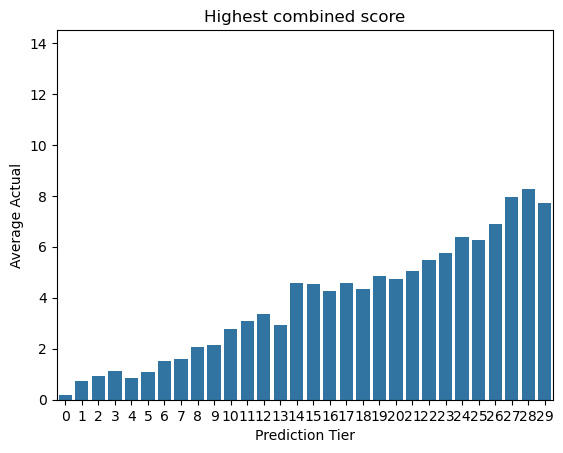

data with highest spearman score
monotonicity: 0.9311, slope: 0.2972, combined score: 0.2358, spearman: 0.3577, gini: 0.4358


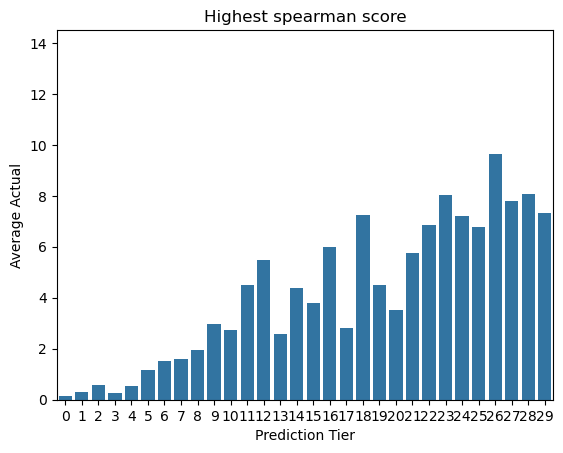

data with highest gini score
monotonicity: 0.9311, slope: 0.2972, combined score: 0.2358, spearman: 0.3577, gini: 0.4358


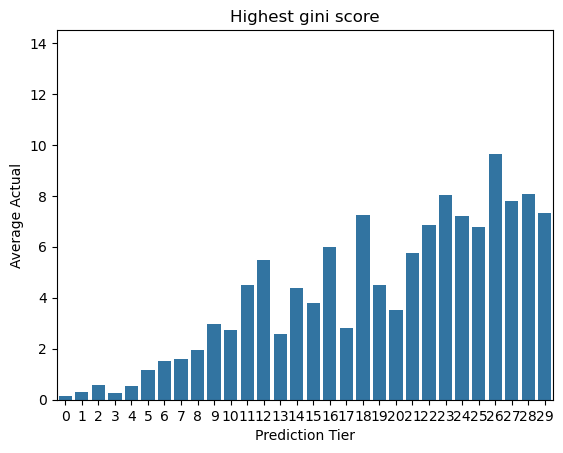

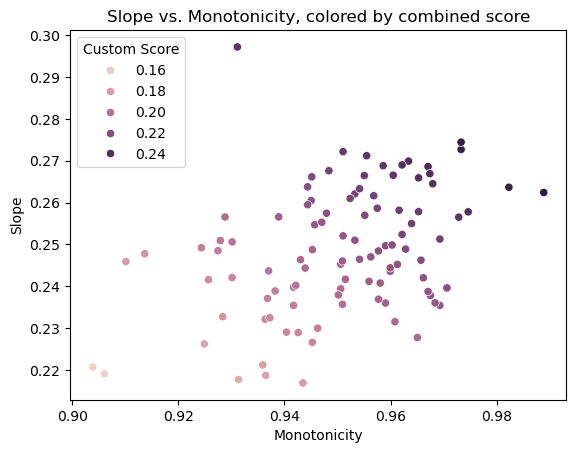

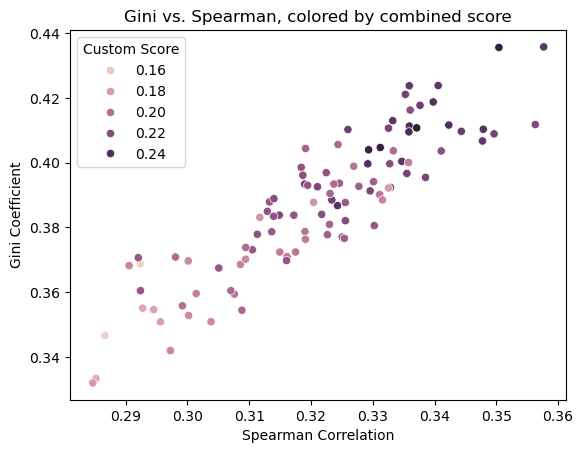

In [164]:
x = score_datasets(dset_good_example, 3, spearmanr)

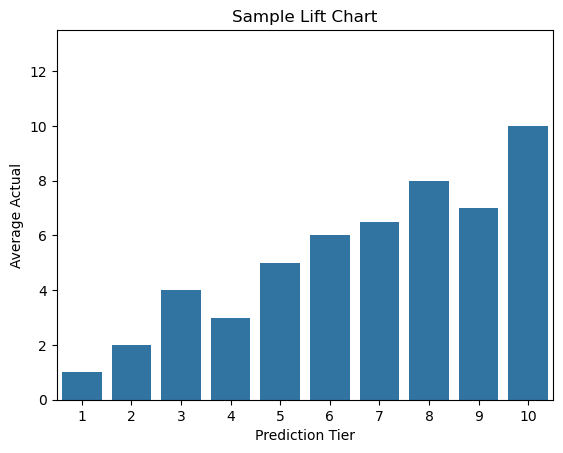

0.9757575757575757


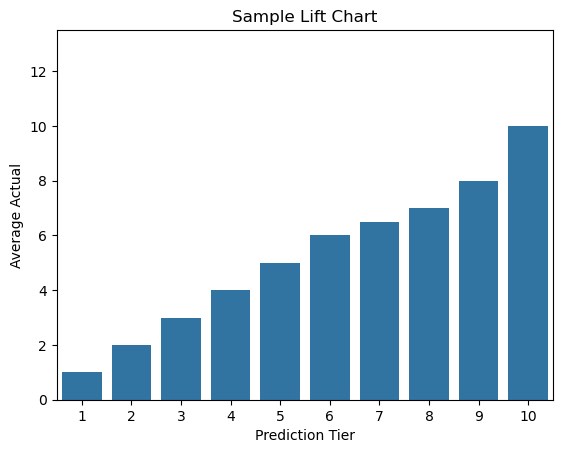

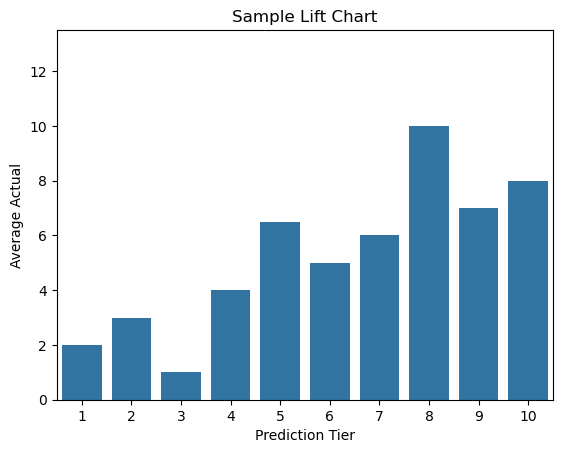

0.8909090909090909


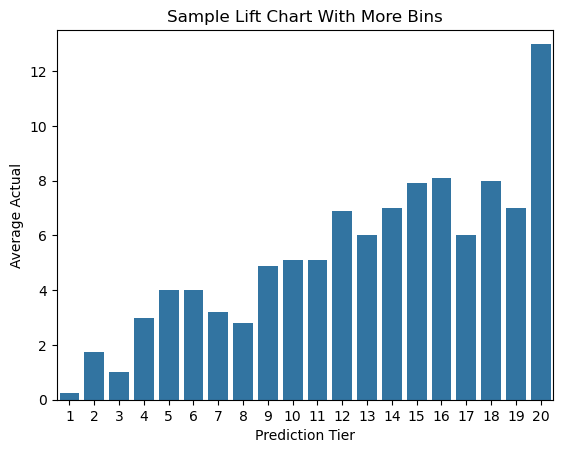

In [7]:
fake_data = [1, 2, 4, 3, 5, 6, 6.5, 8, 7, 10]
fake_data2 = [.25, 1.75, 1, 3, 4, 4, 3.2, 2.8, 4.9, 5.1, 5.1, 6.9, 6, 7, 7.9, 8.1, 6, 8, 7, 13]
fake_scramble = [2, 3, 1, 4, 6.5, 5, 6, 10, 7, 8]



sns.barplot(x = range(1, 11), y = fake_data)
plt.title('Sample Lift Chart')
plt.xlabel('Prediction Tier')
plt.ylabel('Average Actual')
plt.ylim((0, 13.5))
plt.show()
print(spearmanr(range(1, 11), fake_data)[0])

sns.barplot(x = range(1, 11), y = sorted(fake_data))
plt.title('Sample Lift Chart')
plt.xlabel('Prediction Tier')
plt.ylabel('Average Actual')
plt.ylim((0, 13.5))
plt.show()

sns.barplot(x = range(1, 11), y = fake_scramble)
plt.title('Sample Lift Chart')
plt.xlabel('Prediction Tier')
plt.ylabel('Average Actual')
plt.ylim((0, 13.5))
plt.show()
print(spearmanr(range(1, 11), fake_scramble)[0])



sns.barplot(x = range(1, 21), y = fake_data2)
plt.title('Sample Lift Chart With More Bins')
plt.xlabel('Prediction Tier')
plt.ylabel('Average Actual')
plt.ylim((0, 13.5))
plt.show()

In [5]:
# generate a dataset + associated fake predictions
fdata = generate_data(n_samples = 100, n_tiers = 50, prob_dist = create_prob_dist(50), max_value = 49)
p = np.linspace(0, 1, num = 100, endpoint = False).reshape(1, 100)
p = np.repeat(p, 50, axis = 0)
fpreds = p + np.array(range(50)).reshape(-1, 1)


NameError: name 'generate_data' is not defined

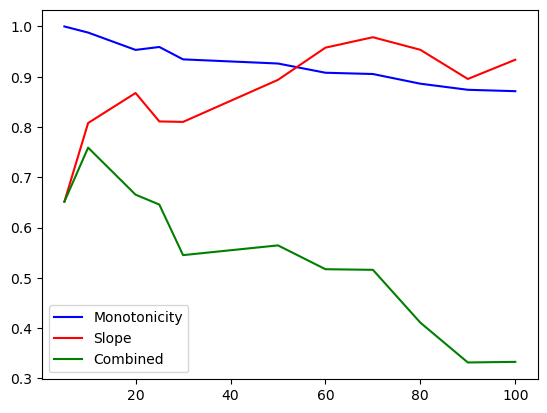

In [150]:
bin_sizes = [5, 10, 20, 25, 30, 50, 60, 70, 80, 90, 100]
scores = np.zeros((len(bin_sizes), 3))

# test it with different bin sizes. display graph and scores.
for idx, tiernum in enumerate(bin_sizes):
    m, s, c = rank_order(fpreds.flatten(), fdata.flatten(), tiernum, verbose = False, monotonicity_metric = spearmanr, penalty = 5, normalize_slope = True)
    scores[idx] = [m, s, c]

plt.plot(bin_sizes, scores[:, 0], color = 'blue', label = 'Monotonicity')
plt.plot(bin_sizes, scores[:, 1], color = 'red', label = 'Slope')
plt.plot(bin_sizes, scores[:, 2], color = 'green', label = 'Combined')
plt.legend()
plt.show()

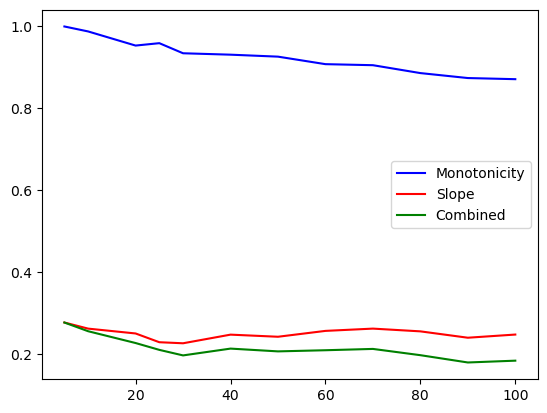

In [157]:
bin_sizes = [5, 10, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
scores = np.zeros((len(bin_sizes), 3))

# test it with different bin sizes. display graph and scores.
for idx, tiernum in enumerate(bin_sizes):
    m, s, c = rank_order_test(fpreds.flatten(), fdata.flatten(), tiernum, verbose = False, monotonicity_metric = spearmanr, penalty = 2, normalize_slope = True)
    scores[idx] = [m, s, c]

plt.plot(bin_sizes, scores[:, 0], color = 'blue', label = 'Monotonicity')
plt.plot(bin_sizes, scores[:, 1], color = 'red', label = 'Slope')
plt.plot(bin_sizes, scores[:, 2], color = 'green', label = 'Combined')
plt.legend()
plt.show()

In [166]:
d = [0, 0, 0, 0, 0, 0, 0, 0.5, 1, 2]

a = pd.qcut(d, 5, duplicates = 'drop')
a

[(-0.001, 0.6], (-0.001, 0.6], (-0.001, 0.6], (-0.001, 0.6], (-0.001, 0.6], (-0.001, 0.6], (-0.001, 0.6], (-0.001, 0.6], (0.6, 2.0], (0.6, 2.0]]
Categories (2, interval[float64, right]): [(-0.001, 0.6] < (0.6, 2.0]]

In [201]:
scores = []
sequences = []
for i in range(100):
    seq = [0] + list(np.random.permutation(range(1, 5))) + list(np.random.permutation(range(5, 10))) + list(np.random.permutation(range(10, 15))) \
        + list(np.random.permutation(range(15, 20))) + list(np.random.permutation(range(20, 25))) + list(np.random.permutation(range(25, 29))) + [29]
    scores.append(spearmanr(range(30), seq)[0])
    sequences.append(seq)

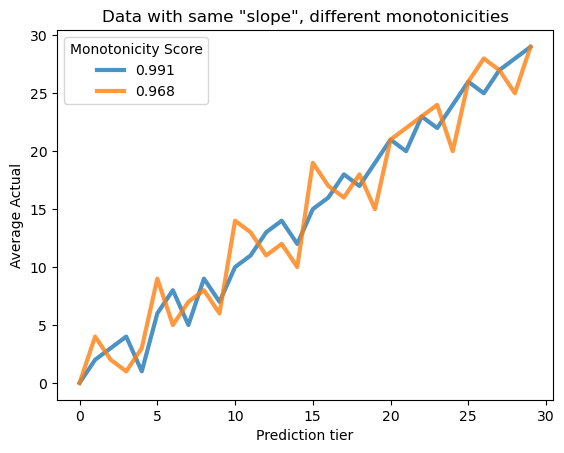

In [203]:
imax = np.argmax(scores)
imin = np.argmin(scores)

plt.plot(range(30), sequences[imax], linewidth = 3, alpha = 0.8, label = round(scores[imax], 3))
plt.plot(range(30), sequences[imin], linewidth = 3, alpha = 0.8, label = round(scores[imin], 3))
plt.legend(title = 'Monotonicity Score')
plt.title('Data with same "slope", different monotonicities')
plt.xlabel('Prediction tier')
plt.ylabel('Average Actual')
plt.show()


The above graph shows two fake datasets with the same "slope", but different spearman correlations.
This resembles the difference in spearmans we might see among similar models for the same data. We can show how different penalties would make these scores differ more:

In [31]:
# mon1 = scores[imax]
# mon2 = scores[imin]

mon1 = 0.991
mon2 = 0.968

for penalty in range(1, 11):
    score1 = 0.5 * (1 - penalty * (1 - mon1))
    score2 = 0.5 * (1 - penalty * (1 - mon2))
    print('Penalty: {}, Blue Score: {: .3f}, Orange Score: {:.3f}'.format(penalty, score1, score2))

Penalty: 1, Blue Score:  0.495, Orange Score: 0.484
Penalty: 2, Blue Score:  0.491, Orange Score: 0.468
Penalty: 3, Blue Score:  0.486, Orange Score: 0.452
Penalty: 4, Blue Score:  0.482, Orange Score: 0.436
Penalty: 5, Blue Score:  0.477, Orange Score: 0.420
Penalty: 6, Blue Score:  0.473, Orange Score: 0.404
Penalty: 7, Blue Score:  0.468, Orange Score: 0.388
Penalty: 8, Blue Score:  0.464, Orange Score: 0.372
Penalty: 9, Blue Score:  0.459, Orange Score: 0.356
Penalty: 10, Blue Score:  0.455, Orange Score: 0.340


In [4]:
# actuals = [0, 0, 0, 0, 0, 0, 0, 1, 2, 10]
# preds = [1, 1, 2, 3, 4, 5, 6, 5, 7, 8]

# sns.barplot(x = range(1, 11), y = actuals)
# plt.title('Tier Distribution of Actuals')
# plt.xlabel('Tier Number')
# plt.ylabel('Average Actual')
# plt.ylim((0, 10.5))
# plt.show()

# sns.barplot(x = range(1, 11), y = preds)
# plt.title('Tier Distribution of Predictions')
# plt.xlabel('Tier Number')
# plt.ylabel('Average Actual')
# plt.ylim((0, 10.5))
# plt.show()

In [3]:
# sns.barplot(x = range(1, 11), y = [0, 1, 1, 2, 3, 4, 3, 6, 7, 10])
# plt.title('Imperfect Monotonicity, High Steepness')
# plt.xlabel('Prediction Tier')
# plt.ylabel('Average Actual')
# plt.ylim((0, 10.5))
# plt.show()